In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
# Import utilities
from setup_utils import setup_db_connection, plr, save_intermediate_data

# Connect to DB and load data
engine = setup_db_connection()

c:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subject_id = 10020187

# 10020187 - 2 hadm_id, +7 unique chart dt, null height
# 10002760 - 1 hadm_id, 2 unique chart dt, has height

In [3]:
# Init subject-based dataframes

# dte cols include hadm_id/stay_id, easily join with age/height/weight tables
# vitals does not have hadm_id, so generally easier to combine after cleaning vitals data
dte_df = pd.read_sql_query(f"""
SELECT t1.subject_id, t1.hadm_id, t1.stay_id, t1.caregiver_id, t1.charttime,
    anchor_age as age,
    weight,
    height
FROM mimiciv.mimiciv_icu.datetimeevents t1
JOIN mimiciv_derived.age t2 ON t1.hadm_id = t2.hadm_id
JOIN mimiciv_derived.weight_durations t3 ON t1.stay_id = t3.stay_id
LEFT JOIN mimiciv_derived.height t4 ON t1.stay_id = t4.stay_id
WHERE t1.subject_id = {subject_id}
GROUP BY t1.subject_id, t1.hadm_id, t1.stay_id, t1.caregiver_id, t1.charttime, anchor_age, weight, height;
""", engine)

v_df = pd.read_sql_query(f"""
SELECT subject_id, stay_id, charttime, heart_rate, sbp, dbp, mbp, resp_rate, temperature, spo2
FROM mimiciv.mimiciv_derived.vitalsign
WHERE subject_id = {subject_id};
""", engine)

rx_df = pd.read_sql_query(f"""
SELECT subject_id, hadm_id, pharmacy_id, starttime 
FROM mimiciv.mimiciv_hosp.prescriptions
WHERE subject_id = {subject_id};
""", engine)

diag_df = pd.read_sql_query(f"""
SELECT * 
FROM mimiciv.mimiciv_hosp.diagnoses_icd
WHERE subject_id = {subject_id};
""", engine)

In [4]:
# Vitals
# List of vital columns to check for NaN
vital_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2']

# Problem: Multiple records can be entered in quick, complimentary succession, mirrors standard practice of collecting vitals. This spikes frequency of NaN, and increases row count.
# Solution: Join records within an established threshold into single row, dropping those which are completely NaN
# Outcome: Improves data quality, reduce frequency of NaN, reduce overall row counts

def consolidate_and_drop_empty_rows(df, time_threshold='13min'):
    """
    Consolidate sequential rows with close charttime values into a single entry,
    and drop rows where all vital columns are NaN.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        time_threshold (str): Time difference threshold (e.g., '15min').
        
    Returns:
        pd.DataFrame: A dataframe with consolidated rows.
    """
    # Ensure charttime is a datetime object
    df['charttime'] = pd.to_datetime(df['charttime'])

    # Sort by charttime
    df = df.sort_values('charttime').reset_index(drop=True)

    
    # Initialize a consolidated dataframe
    consolidated_records = []
    current_record = df.iloc[0].copy()

    for i in range(1, len(df)):
        time_diff = df.loc[i, 'charttime'] - current_record['charttime']
        # Check if the current record has all vital columns as NaN
        
        
        # If the current row is within the time threshold, merge data
        if time_diff <= pd.to_timedelta(time_threshold):
            for col in df.columns:
                if col not in ['subject_id', 'stay_id', 'charttime']:  # Preserve key columns
                    # Take the first non-null value
                    if pd.isna(current_record[col]) and not pd.isna(df.loc[i, col]):
                        current_record[col] = df.loc[i, col]
        else:
            if not current_record[vital_cols].isna().all():            
                # Append the completed record to the results
                consolidated_records.append(current_record)
            # Start a new record
            current_record = df.iloc[i].copy()

    # Append the last record if it has at least one non-NaN vital column
    if not current_record[vital_cols].isna().all():
        consolidated_records.append(current_record)

    # Convert the list of records back to a DataFrame
    consolidated_df = pd.DataFrame(consolidated_records)
    return consolidated_df


print('original vitals df:', v_df.shape, '\nnulls:\n', v_df.isnull().sum()[v_df.isnull().sum() > 0])
v_df = consolidate_and_drop_empty_rows(v_df)
print('\ncleaned vitals df:', v_df.shape, '\nnulls:\n', v_df.isnull().sum()[v_df.isnull().sum() > 0])


original vitals df: (200, 10) 
nulls:
 heart_rate      66
sbp             69
dbp             69
mbp             68
resp_rate       68
temperature    161
spo2            70
dtype: int64

cleaned vitals df: (139, 10) 
nulls:
 heart_rate       9
sbp             12
dbp             12
mbp             11
resp_rate       11
temperature    100
spo2            13
dtype: int64


In [5]:
v_df['charttime'] = pd.to_datetime(v_df['charttime'])
v_df.set_index('charttime', inplace=True)
daily_avg_vitals = v_df[vital_cols].resample('D').mean().dropna(subset=vital_cols).reset_index()
weekly_avg_vitals = v_df[vital_cols].resample('W').mean().dropna(subset=vital_cols).reset_index()
monthly_avg_vitals = v_df[vital_cols].resample('ME').mean().dropna(subset=vital_cols).reset_index()
stay_avg_vitals = v_df.groupby('stay_id')[vital_cols].mean().reset_index()

In [33]:
v_df

,subject_id,stay_id,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2
charttime,,,,,,,,,
2169-01-15 05:00:00,10020187,37509585,75.0,111.0,67.0,77.0,17.0,36.89,96.0
2169-01-15 06:00:00,10020187,37509585,73.0,124.0,70.0,83.0,15.0,NaN,95.0
2169-01-15 07:00:00,10020187,37509585,67.0,108.0,74.0,82.0,15.0,NaN,93.0
2169-01-15 08:00:00,10020187,37509585,66.0,112.0,78.0,82.0,15.0,36.83,94.0
2169-01-15 09:00:00,10020187,37509585,84.0,122.0,75.0,86.0,20.0,NaN,98.0
...,...,...,...,...,...,...,...,...,...
2170-02-25 09:00:00,10020187,32554129,63.0,143.0,74.0,101.0,18.0,NaN,95.0
2170-02-25 09:51:00,10020187,32554129,65.0,120.0,102.0,107.0,18.0,NaN,94.0
2170-02-25 11:00:00,10020187,32554129,62.0,112.0,71.0,85.0,15.0,NaN,96.0


In [28]:
stay_avg_vitals


,stay_id,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2
0,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500
1,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545


In [6]:
# get unique visits
unique_visits = dte_df[['hadm_id', 'stay_id']].drop_duplicates()

# merge rx (starttime) to unique visits; creates sequence of rx orders for each unique visit
rx_unique = rx_df.merge(unique_visits, on=['hadm_id'], how='inner')

# merge diag to unique visits; creates sequence of diagnoses events for each unique visit
diag_unique = diag_df.merge(unique_visits, on=['hadm_id'], how='inner')

# merge dte's height/weight/age into cleaned vitals

# merge stay avg vitals and unique rx
stay_vitals_and_rx = rx_unique.merge(stay_avg_vitals, on=['stay_id'], how='inner')

# merge stay avg vitals and diagnoses events
stay_vitals_and_diag = diag_unique.merge(stay_avg_vitals, on=['stay_id'], how='inner')



In [10]:
stay_vitals_and_diag

,subject_id,hadm_id,seq_num,icd_code,icd_version,stay_id,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2
0,10020187,24104168,1,I6032,10,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545
1,10020187,24104168,2,I10,10,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545
2,10020187,24104168,3,E785,10,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545
3,10020187,24104168,4,I2510,10,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545
4,10020187,24104168,5,E780,10,37509585,66.654545,133.275701,74.205607,96.189815,17.209091,36.890303,95.854545
5,10020187,26842957,1,I671,10,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500
6,10020187,26842957,2,Z6841,10,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500
7,10020187,26842957,3,I10,10,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500
8,10020187,26842957,4,E785,10,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500
9,10020187,26842957,5,E669,10,32554129,62.600000,120.400000,63.000000,82.900000,14.611111,36.760000,95.562500


In [11]:

heart_rate_trends = stay_vitals_and_diag.groupby('stay_id')['heart_rate'].mean()

# Example: Trends in prescriptions by average blood pressure
bp_prescription_trends = stay_vitals_and_rx.groupby('pharmacy_id')['mbp'].mean()

In [12]:
heart_rate_trends


stay_id
32554129    62.600000
37509585    66.654545
Name: heart_rate, dtype: float64

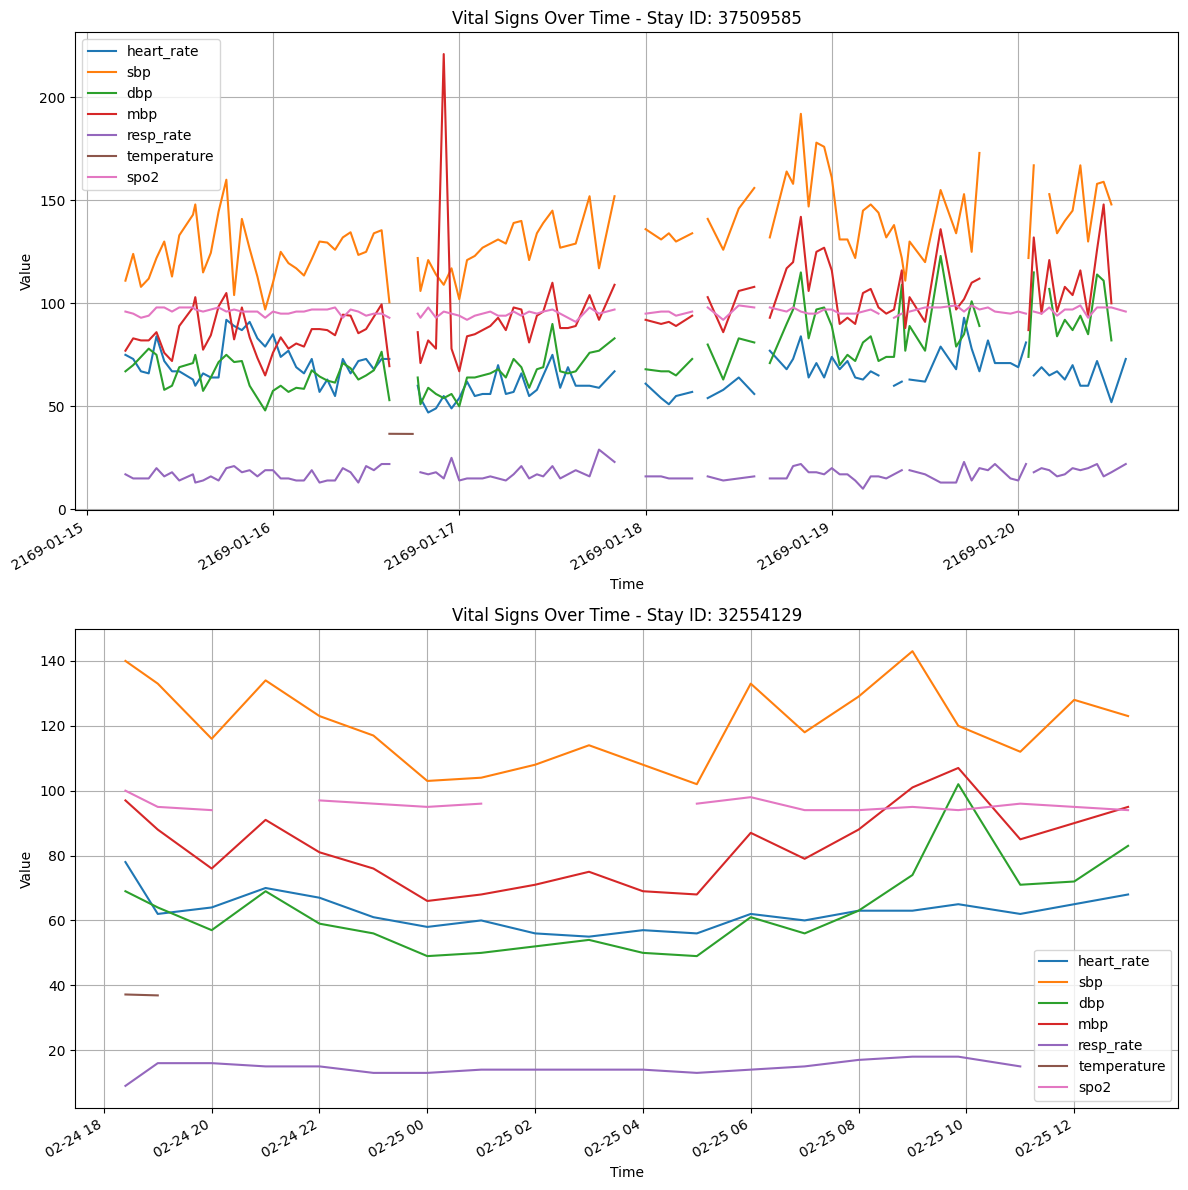

In [34]:
# Create a figure with subplots for each stay_id
stay_ids = v_df['stay_id'].unique()
fig, axes = plt.subplots(len(stay_ids), 1, figsize=(12, 6*len(stay_ids)))

# Plot vitals for each stay_id
for idx, stay_id in enumerate(stay_ids):
    stay_data = v_df[v_df['stay_id'] == stay_id]
    
    # Plot each vital sign
    for vital in vital_cols:
        stay_data[vital].plot(ax=axes[idx], label=vital)
    
    axes[idx].set_title(f'Vital Signs Over Time - Stay ID: {stay_id}')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


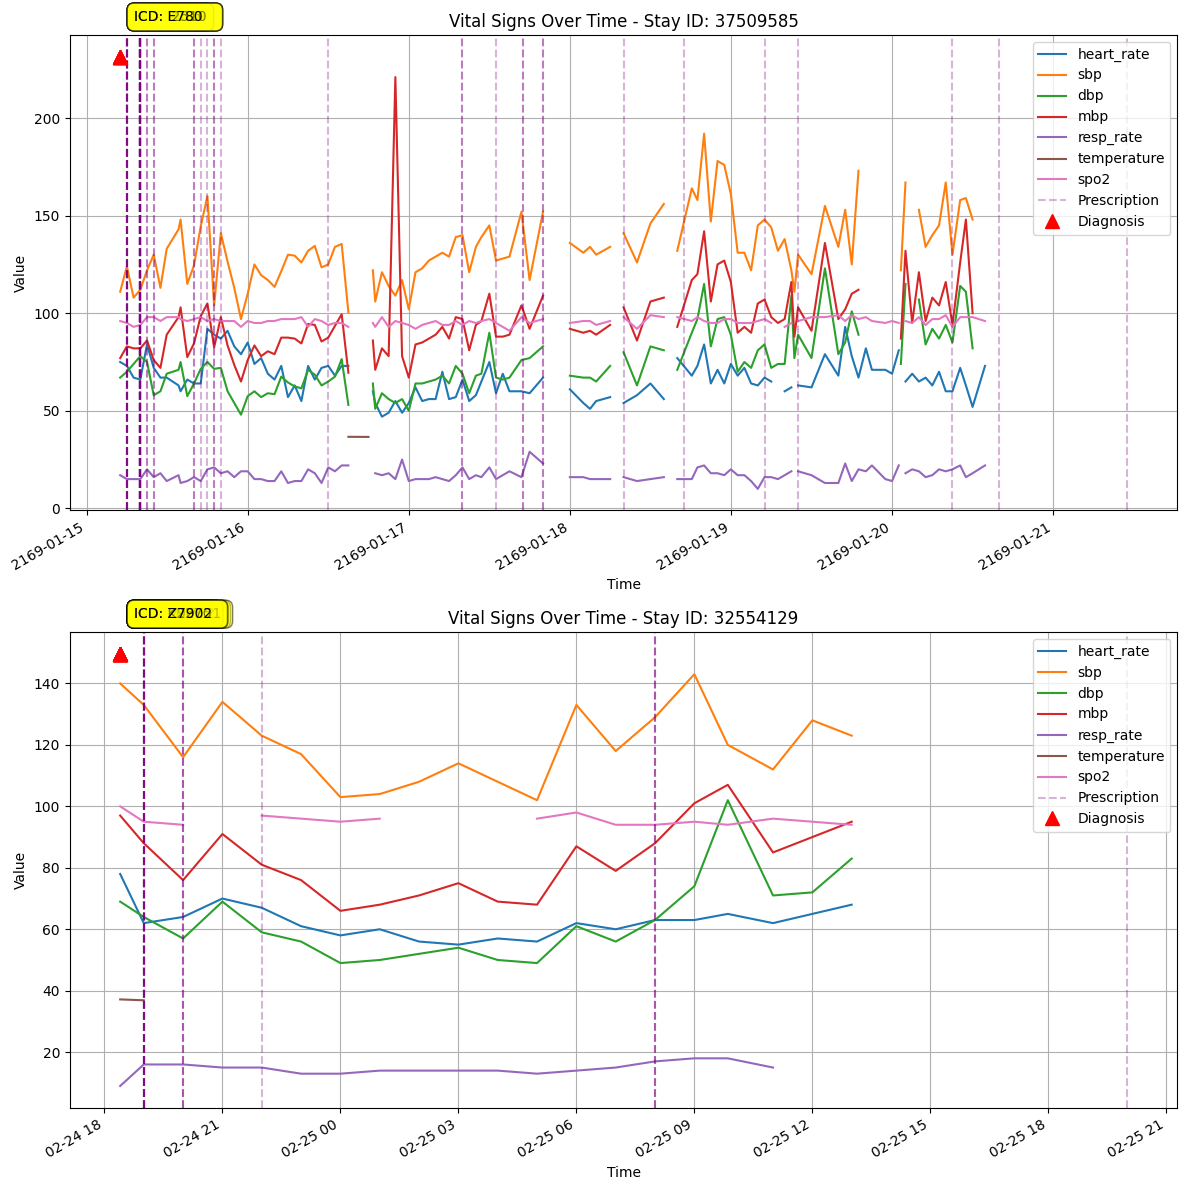

In [35]:
# Create a figure with subplots for each stay_id
stay_ids = v_df['stay_id'].unique()
fig, axes = plt.subplots(len(stay_ids), 1, figsize=(12, 6*len(stay_ids)))

# Plot vitals for each stay_id
for idx, stay_id in enumerate(stay_ids):
    stay_data = v_df[v_df['stay_id'] == stay_id]
    
    # Plot each vital sign
    for vital in vital_cols:
        stay_data[vital].plot(ax=axes[idx], label=vital)
    
    # Add prescription events as vertical lines
    stay_rx = rx_unique[rx_unique['stay_id'] == stay_id]
    for rx_time in stay_rx['starttime']:
        axes[idx].axvline(x=rx_time, color='purple', linestyle='--', alpha=0.3, label='Prescription')
    
    # Add diagnosis events as markers
    stay_diag = diag_unique[diag_unique['stay_id'] == stay_id]
    if len(stay_diag) > 0:
        # Use the first vital reading time as diagnosis time if not available
        diag_times = [stay_data.index[0]] * len(stay_diag)
        axes[idx].plot(diag_times, [axes[idx].get_ylim()[1]] * len(stay_diag), 
                      'r^', markersize=10, label='Diagnosis')
        
        # Add diagnosis codes as annotations
        for i, (_, diag) in enumerate(stay_diag.iterrows()):
            axes[idx].annotate(f'ICD: {diag["icd_code"]}', 
                             xy=(diag_times[i], axes[idx].get_ylim()[1]),
                             xytext=(10, 10), textcoords='offset points',
                             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    axes[idx].set_title(f'Vital Signs Over Time - Stay ID: {stay_id}')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Value')
    
    # Remove duplicate labels
    handles, labels = axes[idx].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[idx].legend(by_label.values(), by_label.keys())
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

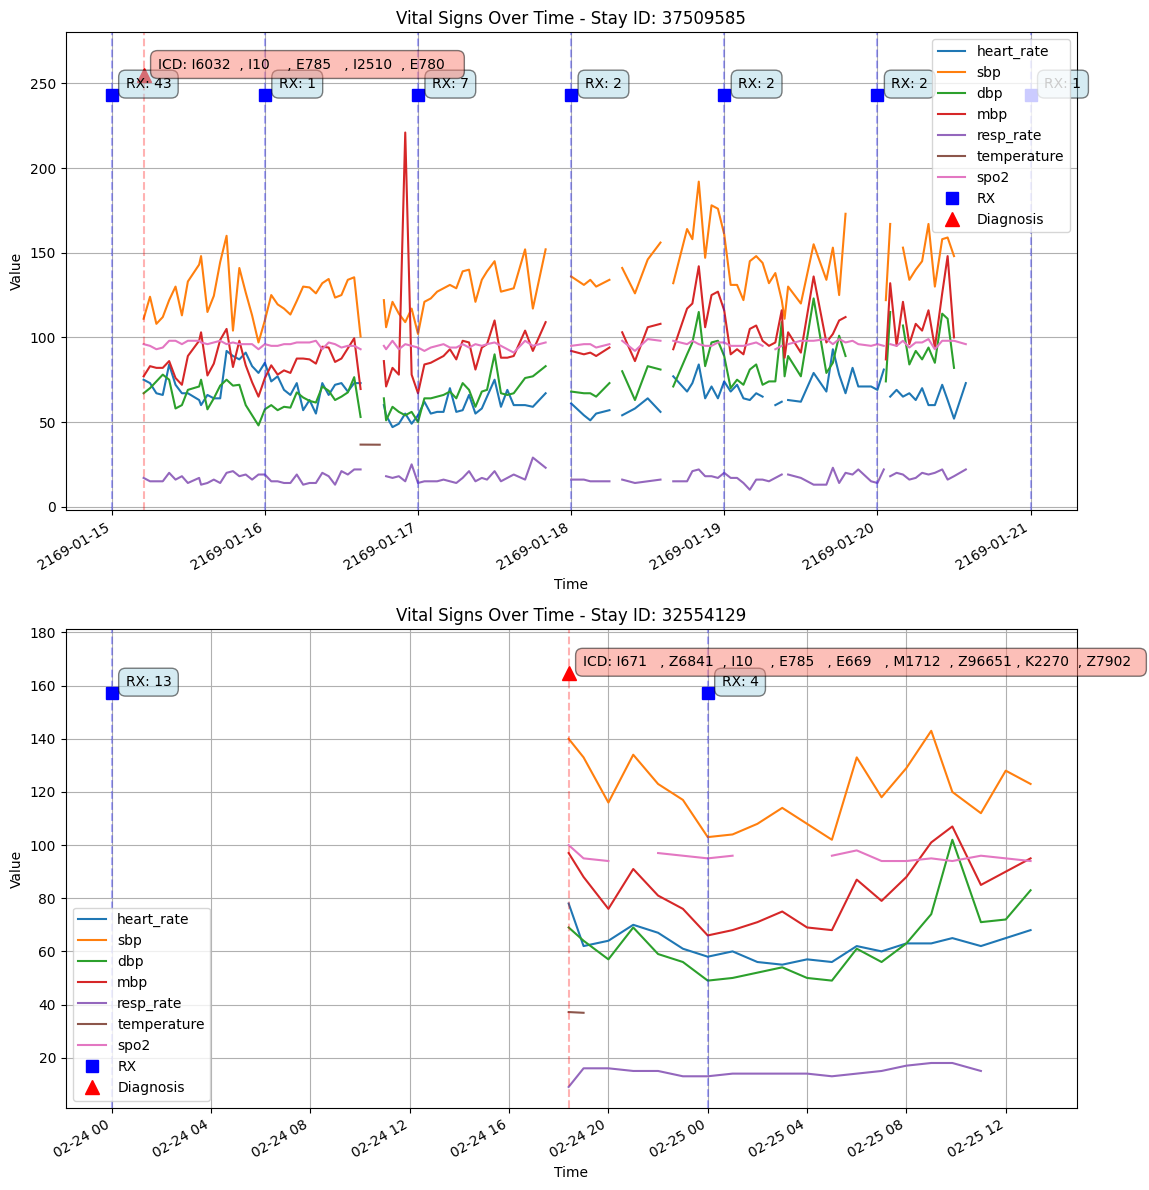


Prescription Summary by Stay ID:
--------------------------------------------------

Stay ID: 37509585

2169-01-15:
  Total prescriptions: 43
  Pharmacy IDs: 6088913, 9548642, 11262209, 11754610, 21368566, 24144896, 25082196, 30724735, 41263455, 42554805, 43223840, 46951137, 47074461, 50149387, 52758458, 53148716, 54123025, 56466157, 64276272, 64881304, 68457729, 68641195, 69000894, 71777379, 71878513, 77010308, 79154069, 83077953, 86623323, 94403176, 96105200

2169-01-16:
  Total prescriptions: 1
  Pharmacy IDs: 13426751

2169-01-17:
  Total prescriptions: 7
  Pharmacy IDs: 30070485, 35398919, 54671397, 61164870, 64772558, 85812596, 99102427

2169-01-18:
  Total prescriptions: 2
  Pharmacy IDs: 20256025, 49882527

2169-01-19:
  Total prescriptions: 2
  Pharmacy IDs: 71184926, 84833718

2169-01-20:
  Total prescriptions: 2
  Pharmacy IDs: 14744666, 28297437

2169-01-21:
  Total prescriptions: 1
  Pharmacy IDs: 12315296

Stay ID: 32554129

2170-02-24:
  Total prescriptions: 13
  Pharma

In [36]:
# Create a figure with subplots for each stay_id
stay_ids = v_df['stay_id'].unique()
fig, axes = plt.subplots(len(stay_ids), 1, figsize=(12, 6*len(stay_ids)))

# Plot vitals for each stay_id
for idx, stay_id in enumerate(stay_ids):
    stay_data = v_df[v_df['stay_id'] == stay_id]
    ax = axes[idx] if len(stay_ids) > 1 else axes
    
    # Plot each vital sign
    for vital in vital_cols:
        stay_data[vital].plot(ax=ax, label=vital)
    
    # Get y-axis limits for marker placement
    y_max = ax.get_ylim()[1]
    marker_positions = [y_max * 1.05, y_max * 1.1]  # Two levels for RX and Diagnosis markers
    
    # Add prescription events
    stay_rx = rx_unique[rx_unique['stay_id'] == stay_id]
    rx_by_day = stay_rx.groupby(pd.to_datetime(stay_rx['starttime']).dt.date).size()
    
    for date, count in rx_by_day.items():
        # Add vertical line
        ax.axvline(x=pd.Timestamp(date), color='blue', linestyle='--', alpha=0.3)
        # Add RX count marker
        ax.plot(pd.Timestamp(date), marker_positions[0], 'bs', markersize=8, label='RX' if date == rx_by_day.index[0] else "")
        ax.annotate(f'RX: {count}', 
                   xy=(pd.Timestamp(date), marker_positions[0]),
                   xytext=(10, 5), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
    
    # Add diagnosis events
    stay_diag = diag_unique[diag_unique['stay_id'] == stay_id]
    if len(stay_diag) > 0:
        diag_time = stay_data.index[0]  # Using first vital reading time
        # Add vertical line
        ax.axvline(x=diag_time, color='red', linestyle='--', alpha=0.3)
        # Add diagnosis markers and codes
        ax.plot(diag_time, marker_positions[1], 'r^', markersize=10, label='Diagnosis')
        
        # Group diagnoses into a single annotation
        diag_codes = ', '.join(stay_diag['icd_code'].astype(str))
        ax.annotate(f'ICD: {diag_codes}', 
                   xy=(diag_time, marker_positions[1]),
                   xytext=(10, 5), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='salmon', alpha=0.5))
    
    ax.set_title(f'Vital Signs Over Time - Stay ID: {stay_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    
    # Adjust y-axis to accommodate markers
    ax.set_ylim(ax.get_ylim()[0], marker_positions[1] * 1.1)
    
    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(True)

plt.tight_layout()
plt.show()

# Print prescription summary
print("\nPrescription Summary by Stay ID:")
print("-" * 50)
for stay_id in stay_ids:
    stay_rx = rx_unique[rx_unique['stay_id'] == stay_id]
    print(f"\nStay ID: {stay_id}")
    rx_by_day = stay_rx.groupby(pd.to_datetime(stay_rx['starttime']).dt.date)
    
    for date, group in rx_by_day:
        print(f"\n{date.strftime('%Y-%m-%d')}:")
        print(f"  Total prescriptions: {len(group)}")
        print(f"  Pharmacy IDs: {', '.join(map(str, group['pharmacy_id'].unique()))}")